In [1]:
import glob
import wandb
import fasttext
import numpy as np
import pandas as pd
from rich import print
from pathlib import Path
from tqdm.auto import tqdm
from dotenv import load_dotenv
from collections import defaultdict
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report,
                             ConfusionMatrixDisplay)

In [2]:
sns.set_theme(context='notebook', style='dark')
tqdm.pandas()

In [3]:
load_dotenv()
wandb.login()

wandb: Currently logged in as: e_hossam96. Use `wandb login --relogin` to force relogin


True

In [4]:
# wandb configs
PROJECT_NAME = 'ARABIC_DISAMBIGUATION_STUDY'
JOB_TYPE = 'MODELING'
TAGS = ['MODELING', 'BASELINE', 'LOGISTIC_REGRESSION', 'TOPIC']
NOTES = 'Baseline modeling using Logistic Regression'
RUN_NAME = 'Logistic_Regression_Baseline_Modeling_SANAD'
config = defaultdict(dict)

In [5]:
seed = 42
fasttext_model_path = '../models/cc.ar.300.bin'
to_use_artifact_name = 'Topic-Classification-Dataset:latest'

In [6]:
run = wandb.init(project=PROJECT_NAME, job_type=JOB_TYPE,
                 name=RUN_NAME, notes=NOTES, tags=TAGS, config=config)

In [7]:
data_artifact = run.use_artifact(to_use_artifact_name)

In [8]:
data_path = data_artifact.download(
    root=Path(f'../data/{to_use_artifact_name}'))

wandb: Downloading large artifact Topic-Classification-Dataset:latest, 83.38MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:3.7


In [9]:
data_path = Path(data_path)

In [10]:
data_dict = {}
for f in glob.glob(f'{str(data_path)}/*'):
    data_dict[f.split('/')[-1]] = pd.read_csv(f)

In [11]:
data_dict['train'].head(2)

,text,label,processed_text,processed_text_arabert
0,عبدالاله بوسحابة : اخبارنا المغربية\nتمثيلية م...,Sports,عبدالاله بوسحابة: اخبارنا المغربية تمثيلية مشر...,عبدالاله ب+ وسحاب +ة : اخبار +نا ال+ مغربي +ة ...
1,تؤدي الكلى وظائف رئيسية في الجسم أهمها التخلص ...,Medical,تؤدي الكلى وظائف رئيسية في الجسم أهمها التخلص ...,تؤدي ال+ كلى وظائف رئيسي +ة في ال+ جسم أهم +ها...


In [12]:
encoder = fasttext.load_model(fasttext_model_path)

In [13]:
label_names = data_dict['train'].label.unique()
label_names

array(['Sports', 'Medical', 'Politics', 'Finance', 'Tech', 'Religion',
       'Culture'], dtype=object)

In [14]:
label2id = {label_names[i]: i for i in range(len(label_names))}
id2label = {i: label_names[i] for i in range(len(label_names))}

In [15]:
for n, d in data_dict.items():
    data_dict[n]['vectors'] = d.processed_text.progress_apply(
        encoder.get_sentence_vector)
    data_dict[n]['label_id'] = d.label.apply(lambda x: label2id[x])

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [16]:
del encoder

In [17]:
data_dict['train'].head(2)

,text,label,processed_text,processed_text_arabert,vectors,label_id
0,عبدالاله بوسحابة : اخبارنا المغربية\nتمثيلية م...,Sports,عبدالاله بوسحابة: اخبارنا المغربية تمثيلية مشر...,عبدالاله ب+ وسحاب +ة : اخبار +نا ال+ مغربي +ة ...,"[0.005864457, 0.021170583, 0.0028850127, 0.051...",0
1,تؤدي الكلى وظائف رئيسية في الجسم أهمها التخلص ...,Medical,تؤدي الكلى وظائف رئيسية في الجسم أهمها التخلص ...,تؤدي ال+ كلى وظائف رئيسي +ة في ال+ جسم أهم +ها...,"[0.0123263365, -0.0051977704, -0.014825693, 0....",1


In [18]:
class_weights = data_dict['train'].label_id.value_counts(
    normalize=True).to_dict()
class_weights

{3: 0.2775,
 0: 0.2085,
 2: 0.1445,
 1: 0.13725,
 4: 0.131875,
 5: 0.05275,
 6: 0.047625}

In [19]:
model = LogisticRegression(class_weight=class_weights,
                           max_iter=int(1e3), random_state=seed, C=1.0)

In [20]:
model.fit(data_dict['train'].vectors.to_list(),
          data_dict['train'].label_id.to_list())

LogisticRegression(class_weight={0: 0.2085, 1: 0.13725, 2: 0.1445, 3: 0.2775,
                                 4: 0.131875, 5: 0.05275, 6: 0.047625},
                   max_iter=1000, random_state=42)

In [21]:
X_test = data_dict['test'].vectors.to_list()
y_true = data_dict['test'].label_id.to_list()
y_prob = model.predict_proba(X_test)
y_pred = model.predict(X_test)

In [22]:
print(classification_report(y_true, y_pred, target_names=label_names, digits=4))

/home/hossam/miniconda3/envs/disambg/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hossam/miniconda3/envs/disambg/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hossam/miniconda3/envs/disambg/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

precision    recall  f1-score   support

      Sports     0.8042    0.9279    0.8616       208
     Medical     0.9583    0.5036    0.6603       137
    Politics     0.4091    0.0621    0.1078       145
     Finance     0.4233    0.9964    0.5942       277
        Tech     1.0000    0.1061    0.1918       132
    Religion     0.0000    0.0000    0.0000        53
     Culture     0.0000    0.0000    0.0000        48

    accuracy                         0.5610      1000
   macro avg     0.5136    0.3709    0.3451      1000
weighted avg     0.6071    0.5610    0.4752      1000

In [23]:
summary = {}

summary['test_f1'] = f1_score(y_true, y_pred, average='macro')
summary['test_precision'] = precision_score(y_true, y_pred, average='macro')
summary['test_recall'] = recall_score(y_true, y_pred, average='macro')
summary

/home/hossam/miniconda3/envs/disambg/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'test_f1': 0.34509239648892337,
 'test_precision': 0.5135576846466418,
 'test_recall': 0.37086481624224427}

In [24]:
for k, v in summary.items():
    run.summary[k] = v

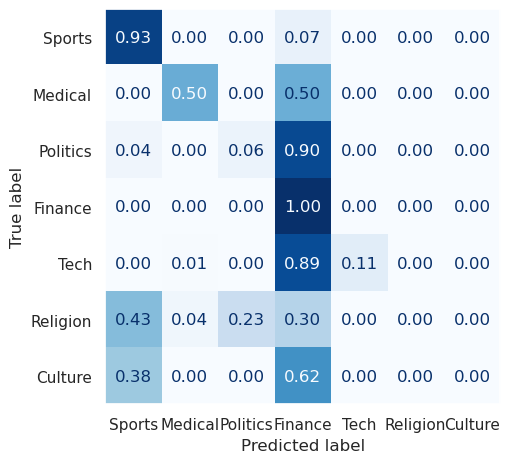

In [25]:
cm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

fig, ax = plt.subplots()
ax.grid(False)
disp.plot(cmap="Blues", colorbar=False, ax=ax, values_format='.2f')
plt.tight_layout()
plt.show()

In [26]:
run.log({'Topic Classification Test Confusion Matrix': wandb.plot.confusion_matrix(
    y_true=y_true, preds=y_pred, class_names=label_names)})

In [27]:
run.finish()

test_f1,0.34509
test_precision,0.51356
test_recall,0.37086
